In [1]:
# !wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/segmentation.zip && unzip segmentation.zip

In [2]:
# !mv segmentation/* .

In [3]:
# !rm -rf segmentation segmentation.zip

In [4]:
import random
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import cv2
import matplotlib.pyplot as plt

In [5]:
try:
    import segmentation_models_pytorch as smp
except:
    !pip install segmentation-models-pytorch
    import segmentation_models_pytorch as smp

In [6]:
images = np.load("dataset/image_180_320.npy")
labels = np.load("dataset/label_180_320.npy")

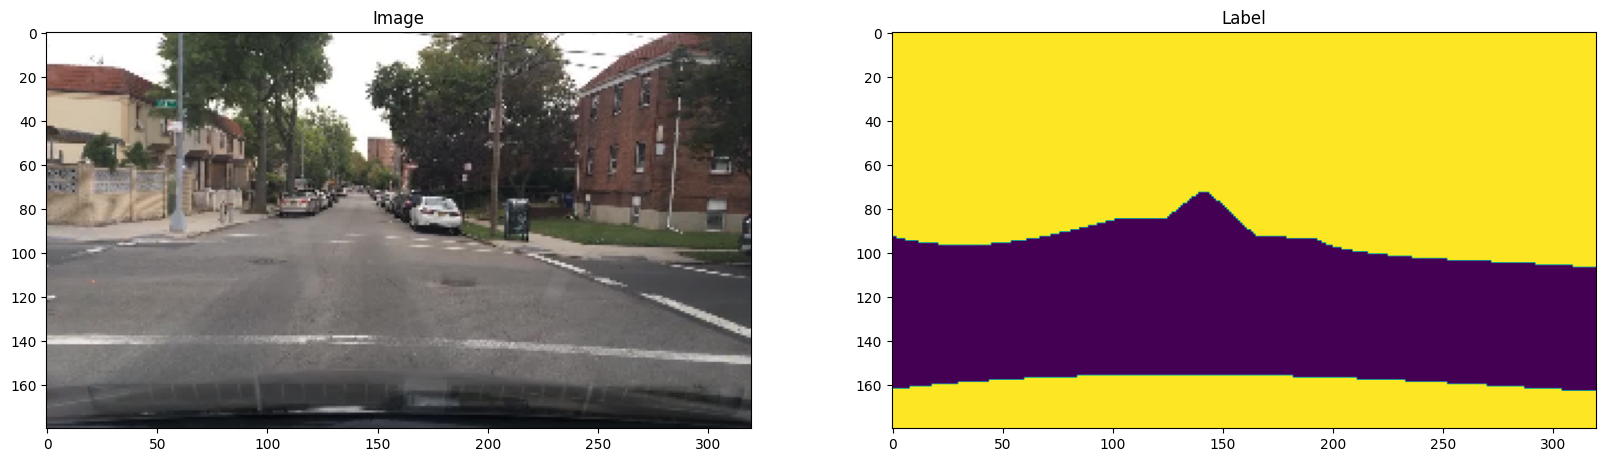

In [7]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 10))
idx = np.random.randint(0, len(images))
ax0.imshow(images[idx])
ax0.set_title("Image")
ax1.imshow(labels[idx])
ax1.set_title("Label")
plt.show()

In [8]:
print(len(images))
print(len(images[0]))
print(images.shape)

3430
180
(3430, 180, 320, 3)


In [9]:
from collections import namedtuple

# Each label is a tuple with name, class id, and color
Label = namedtuple("Label", ["name", "id", "color"])
drivables = [
             Label("direct", 0, (171, 44, 236)),      # purple
             Label("alternative", 1, (86, 211, 19)),  # green
             Label("background", 2, (0, 0, 0)),       # black
            ]

train_id_to_color = [c.color for c in drivables if (c.id != -1 and c.id != 255)]
train_id_to_color = np.array(train_id_to_color)
print(f"train_id_to_color: {train_id_to_color}")

train_id_to_color: [[171  44 236]
 [ 86 211  19]
 [  0   0   0]]


(-0.5, 319.5, 179.5, -0.5)

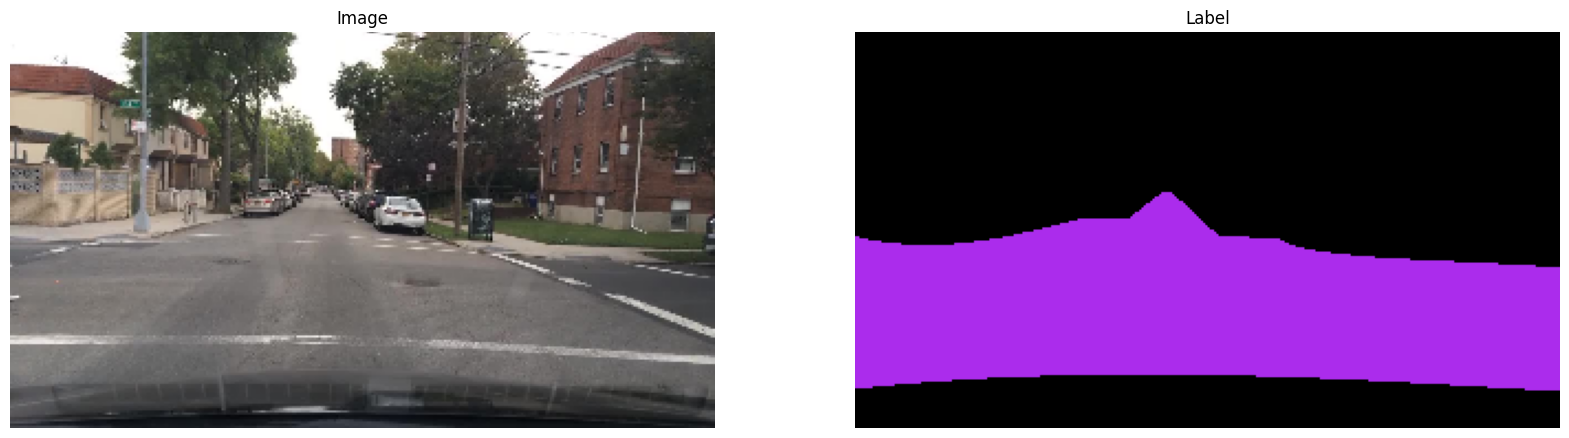

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(images[idx])
axes[0].set_title("Image")
axes[0].axis("off")
axes[1].imshow(train_id_to_color[labels[idx]])
axes[1].set_title("Label")
axes[1].axis("off")

# Dataset and Dataloader

In [11]:
from torch.utils.data import Dataset, DataLoader

class BDD100k_dataset(Dataset):
    def __init__(self, images, labels, tf):
        self.images = images
        self.labels = labels
        self.tf = tf

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        # read source image and convert to RGB, apply transform
        rgb_image = self.images[index]
        if self.tf is not None:
            rgb_image = self.tf(rgb_image)

        # read label image and convert to torch tensor
        label_image  = torch.from_numpy(self.labels[index]).long()
        return rgb_image, label_image

## Transforms

In [12]:
from torchvision import transforms
preprocess = transforms.Compose([
    # transforms.ToPILImage(),
    # transforms.Resize((180, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [13]:
def get_dataset(images, labels):
    data = BDD100k_dataset(images, labels, tf=preprocess)
    total_count = len(data)
    train_count = int(total_count * 0.7)
    val_count = int(total_count * 0.2)
    test_count = total_count - train_count - val_count
    train_data, val_data, test_data = torch.utils.data.random_split(data, (train_count, val_count, test_count),
                                                                    generator=torch.Generator().manual_seed(42))
    return train_data, val_data, test_data

In [14]:
def get_dataloader(train_set, val_set,test_set):
    train_loader = DataLoader(train_set, batch_size=8, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=8, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=8, shuffle=False)
    return train_loader, val_loader, test_loader

In [15]:
train_set, val_set, test_set = get_dataset(images, labels)
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} images in the training set, {len(val_set)} images in the validation set, and {len(test_set)} images in the test set.")
print(f"Each image has shape {sample_image.shape} and each label has shape {sample_label.shape}.")


There are 2401 images in the training set, 686 images in the validation set, and 343 images in the test set.
Each image has shape torch.Size([3, 180, 320]) and each label has shape torch.Size([180, 320]).


In [16]:
train_dataloader, val_dataloader, test_dataloader = get_dataloader(train_set, val_set, test_set)

## Samples

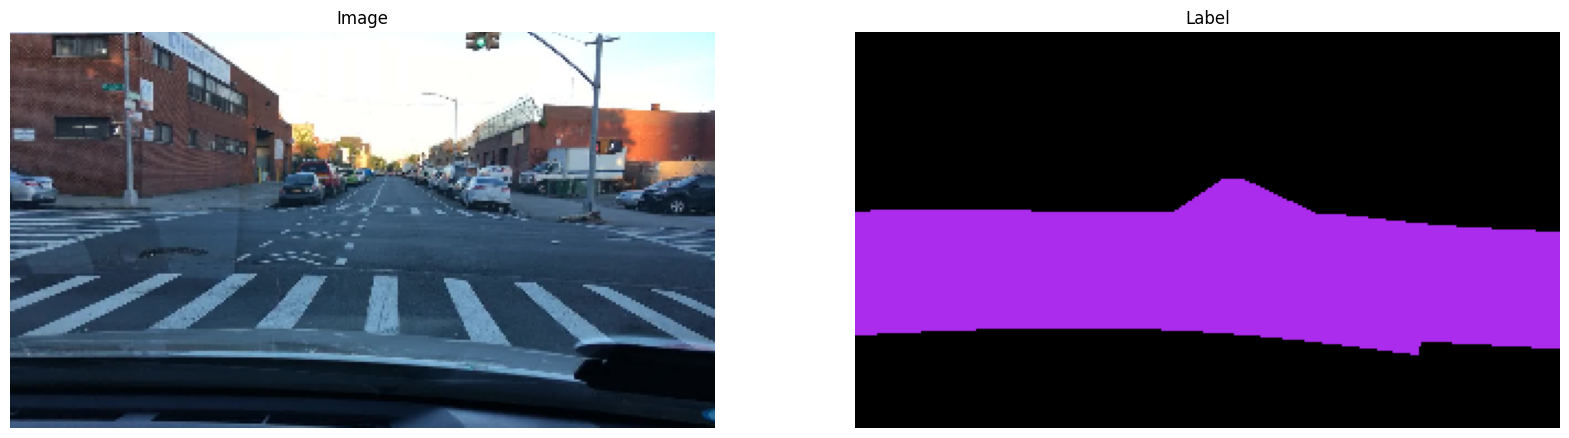

In [17]:
try:
    from utils import inverse_transform
except:
    !pip install pandas
    from utils import inverse_transform

rgb_image, label = train_set[np.random.choice(len(train_set))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot
_, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image)
axes[0].set_title("Image")
axes[0].axis("off")
axes[1].imshow(train_id_to_color[label])
axes[1].set_title("Label")
axes[1].axis("off")
plt.show()

# U-Net Model

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

## Encoder

In [18]:
def double_conv(in_channels, out_channels):
    conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                         nn.BatchNorm2d(out_channels),
                         nn.ReLU(inplace=True),
                         nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                         nn.BatchNorm2d(out_channels),
                         nn.ReLU(inplace=True)
                        )
    return conv

In [19]:
class UNetEncoder(nn.Module):
    def __init__(self, in_channels, layer_channels):
        super().__init__()
        self.encoder = nn.ModuleList()

        for num_channels in layer_channels:
            self.encoder.append(double_conv(in_channels, num_channels))
            in_channels = num_channels

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        skip_connections = []
        for downsample in self.encoder:
            x = downsample(x)
            skip_connections.append(x)
            x = self.pool(x)
        return x, skip_connections

## Decoder

In [20]:
import torchvision.transforms.functional as TF

class UNetDecoder(nn.Module):
    def __init__(self, layer_channels):
        super().__init__()
        self.decoder = nn.ModuleList()
        for num_channels in reversed(layer_channels):
            self.decoder.append(nn.ConvTranspose2d(in_channels=num_channels * 2,
                                                   out_channels=num_channels,
                                                   kernel_size=2, stride=2)
                                )
            self.decoder.append(double_conv(in_channels=num_channels * 2,
                                            out_channels=num_channels)
                                )

    def forward(self, x, skip_connections):
        for i in range(0, len(self.decoder), 2):
            # Up-sample every other step
            x = self.decoder[i](x)

            # If skip connection doesn't match, resize
            skip_connection = skip_connections[i//2] # skip connection at the rest of the steps
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            # Concatenate and pass through the double_conv block
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[i+1](concat_skip)
        return x

## U-Net

In [21]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, layer_channels):
        super(UNet, self).__init__()

        # Encoder and decoder modules
        self.encoder = UNetEncoder(in_channels, layer_channels)
        self.decoder = UNetDecoder(layer_channels)

        # conv layer to transition from encoder to decoder and
        # 1x1 convolution to reduce num channels to out_channels
        self.bottleneck = double_conv(layer_channels[-1], layer_channels[-1]*2)
        self.final_conv = nn.Conv2d(layer_channels[0], out_channels, kernel_size=1)

        # initialize parameters now to avoid modifying the initialization of top_blocks
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=1)
                # nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder blocks
        encoder_output, skip_connections = self.encoder(x)

        # transition between encoder and decoder
        x = self.bottleneck(encoder_output)

        # we need the last skip connection first
        # so reversing the list
        skip_connections = skip_connections[::-1]

        # Decoder blocks
        x = self.decoder(x, skip_connections)

        # final 1x1 conv to match input size
        return self.final_conv(x)

# Training

In [22]:
from utils import meanIoU                  # metric class
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

# reference : https://smp.readthedocs.io/en/latest/losses.html
criterion = smp.losses.DiceLoss('multiclass', classes=[0,1,2], log_loss = True, smooth=1.0)

# MODEL HYPERPARAMETERS
N_EPOCHS = 50
NUM_CLASSES = 3
MAX_LR = 3e-4
MODEL_NAME = 'UNet_baseline'

# create model, optimizer, lr_scheduler and pass to training function
model = UNet(in_channels=3, out_channels=3, layer_channels=[64, 128, 256, 512]).to(device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR, amsgrad=True)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader),
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

In [24]:
output_path = "dataset"

Starting 1 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 1, trainLoss:1.10555, validationLoss:0.78467, meanIoU: 0.48
Starting 2 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 2, trainLoss:0.69167, validationLoss:0.67501, meanIoU: 0.52
Starting 3 epoch ...


100%|██████████| 86/86 [00:25<00:00,  3.31it/s]


Epoch: 3, trainLoss:0.58543, validationLoss:0.54600, meanIoU: 0.57
Starting 4 epoch ...


100%|██████████| 86/86 [00:23<00:00,  3.70it/s]


Epoch: 4, trainLoss:0.47343, validationLoss:0.49135, meanIoU: 0.60
Starting 5 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.97it/s]


Epoch: 5, trainLoss:0.45237, validationLoss:0.43407, meanIoU: 0.60
Starting 6 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.88it/s]


Epoch: 6, trainLoss:0.44041, validationLoss:0.42730, meanIoU: 0.60
Starting 7 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.89it/s]


Epoch: 7, trainLoss:0.37486, validationLoss:0.41175, meanIoU: 0.61
Starting 8 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.95it/s]


Epoch: 8, trainLoss:0.41821, validationLoss:0.80206, meanIoU: 0.42
Starting 9 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.92it/s]


Epoch: 9, trainLoss:0.47349, validationLoss:0.43585, meanIoU: 0.58
Starting 10 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.95it/s]


Epoch: 10, trainLoss:0.39964, validationLoss:0.37076, meanIoU: 0.62
Starting 11 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.95it/s]


Epoch: 11, trainLoss:0.43030, validationLoss:0.39440, meanIoU: 0.61
Starting 12 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.95it/s]


Epoch: 12, trainLoss:0.43101, validationLoss:0.36216, meanIoU: 0.63
Starting 13 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.93it/s]


Epoch: 13, trainLoss:0.32593, validationLoss:0.32342, meanIoU: 0.65
Starting 14 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 14, trainLoss:0.33132, validationLoss:0.30894, meanIoU: 0.66
Starting 15 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.90it/s]


Epoch: 15, trainLoss:0.28663, validationLoss:0.29737, meanIoU: 0.67
Starting 16 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 16, trainLoss:0.34659, validationLoss:0.31514, meanIoU: 0.66
Starting 17 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.97it/s]


Epoch: 17, trainLoss:0.29939, validationLoss:0.31019, meanIoU: 0.66
Starting 18 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.96it/s]


Epoch: 18, trainLoss:0.26744, validationLoss:0.28135, meanIoU: 0.68
Starting 19 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.97it/s]


Epoch: 19, trainLoss:0.24277, validationLoss:0.29523, meanIoU: 0.68
Starting 20 epoch ...


100%|██████████| 86/86 [00:26<00:00,  3.28it/s]


Epoch: 20, trainLoss:0.24481, validationLoss:0.26801, meanIoU: 0.69
Starting 21 epoch ...


100%|██████████| 86/86 [00:25<00:00,  3.31it/s]


Epoch: 21, trainLoss:0.22927, validationLoss:0.28613, meanIoU: 0.68
Starting 22 epoch ...


100%|██████████| 86/86 [00:25<00:00,  3.33it/s]


Epoch: 22, trainLoss:0.25432, validationLoss:0.27118, meanIoU: 0.68
Starting 23 epoch ...


100%|██████████| 86/86 [00:26<00:00,  3.30it/s]


Epoch: 23, trainLoss:0.21846, validationLoss:0.25728, meanIoU: 0.70
Starting 24 epoch ...


100%|██████████| 86/86 [00:26<00:00,  3.30it/s]


Epoch: 24, trainLoss:0.25433, validationLoss:0.32081, meanIoU: 0.65
Starting 25 epoch ...


100%|██████████| 86/86 [00:26<00:00,  3.28it/s]


Epoch: 25, trainLoss:0.26223, validationLoss:0.31180, meanIoU: 0.66
Starting 26 epoch ...


100%|██████████| 86/86 [00:26<00:00,  3.29it/s]


Epoch: 26, trainLoss:0.25519, validationLoss:0.27476, meanIoU: 0.69
Starting 27 epoch ...


100%|██████████| 86/86 [00:26<00:00,  3.30it/s]


Epoch: 27, trainLoss:0.23509, validationLoss:0.26087, meanIoU: 0.69
Starting 28 epoch ...


100%|██████████| 86/86 [00:26<00:00,  3.31it/s]


Epoch: 28, trainLoss:0.19306, validationLoss:0.25212, meanIoU: 0.70
Starting 29 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.84it/s]


Epoch: 29, trainLoss:0.32940, validationLoss:0.31198, meanIoU: 0.65
Starting 30 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.88it/s]


Epoch: 30, trainLoss:0.27114, validationLoss:0.34215, meanIoU: 0.64
Starting 31 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.88it/s]


Epoch: 31, trainLoss:0.26351, validationLoss:0.27915, meanIoU: 0.69
Starting 32 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.90it/s]


Epoch: 32, trainLoss:0.21694, validationLoss:0.25853, meanIoU: 0.70
Starting 33 epoch ...


100%|██████████| 86/86 [00:22<00:00,  3.88it/s]


Epoch: 33, trainLoss:0.20093, validationLoss:0.25843, meanIoU: 0.70
Starting 34 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.04it/s]


Epoch: 34, trainLoss:0.19473, validationLoss:0.24547, meanIoU: 0.71
Starting 35 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.05it/s]


Epoch: 35, trainLoss:0.18356, validationLoss:0.24570, meanIoU: 0.71
Starting 36 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 36, trainLoss:0.17494, validationLoss:0.24165, meanIoU: 0.71
Starting 37 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 37, trainLoss:0.16040, validationLoss:0.24921, meanIoU: 0.70
Starting 38 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 38, trainLoss:0.16125, validationLoss:0.24279, meanIoU: 0.71
Starting 39 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 39, trainLoss:0.15459, validationLoss:0.24113, meanIoU: 0.71
Starting 40 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.03it/s]


Epoch: 40, trainLoss:0.16773, validationLoss:0.27991, meanIoU: 0.68
Starting 41 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 41, trainLoss:0.16738, validationLoss:0.24943, meanIoU: 0.71
Starting 42 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 42, trainLoss:0.15879, validationLoss:0.25856, meanIoU: 0.70
Starting 43 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.04it/s]


Epoch: 43, trainLoss:0.16672, validationLoss:0.25145, meanIoU: 0.71
Starting 44 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 44, trainLoss:0.14269, validationLoss:0.24909, meanIoU: 0.71
Starting 45 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.03it/s]


Epoch: 45, trainLoss:0.13796, validationLoss:0.24735, meanIoU: 0.71
Starting 46 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.03it/s]


Epoch: 46, trainLoss:0.13558, validationLoss:0.24750, meanIoU: 0.71
Starting 47 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 47, trainLoss:0.13343, validationLoss:0.24352, meanIoU: 0.71
Starting 48 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.03it/s]


Epoch: 48, trainLoss:0.13484, validationLoss:0.24303, meanIoU: 0.71
Starting 49 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 49, trainLoss:0.13180, validationLoss:0.24560, meanIoU: 0.71
Starting 50 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]

Epoch: 50, trainLoss:0.13348, validationLoss:0.24222, meanIoU: 0.71


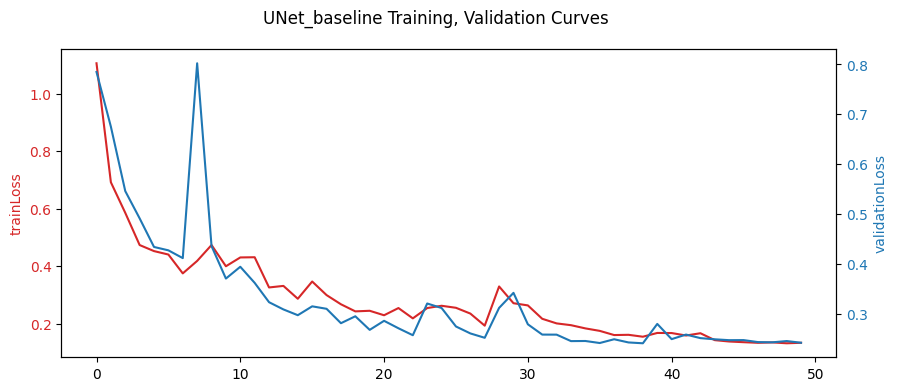

In [25]:
_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer,
                         device, train_dataloader, val_dataloader, meanIoU, 'meanIoU',
                         NUM_CLASSES, lr_scheduler = scheduler, output_path = output_path)

# Results

In [26]:
model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device))
_, test_metric = evaluate_model(model, test_dataloader, criterion, meanIoU, NUM_CLASSES, device)
print(f"\nModel has {test_metric} mean IoU in test set")

100%|██████████| 43/43 [00:10<00:00,  4.16it/s]


Model has 0.726087126326429 mean IoU in test set


In [27]:
from utils import visualize_predictions

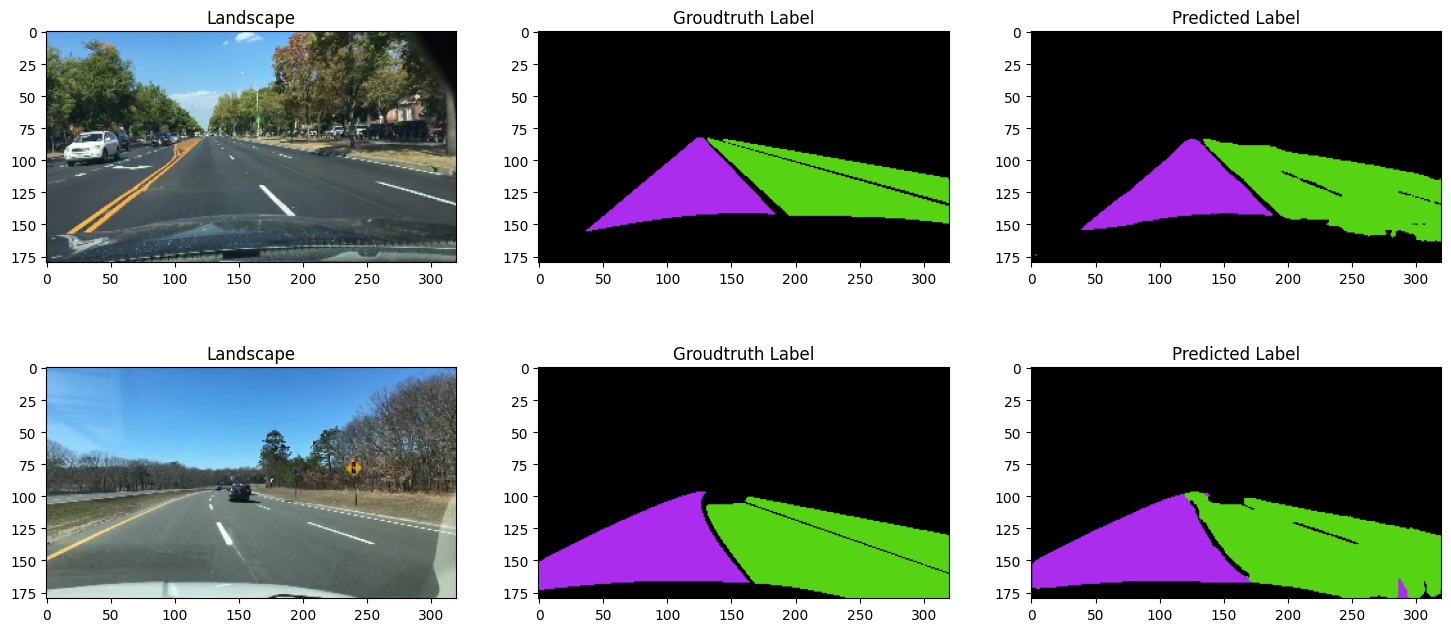

In [29]:
num_test_samples = 2
_, axes = plt.subplots(num_test_samples, 3, figsize=(3*6, num_test_samples * 4))
visualize_predictions(model, test_set, axes, device, numTestSamples=num_test_samples, id_to_color=train_id_to_color)

In [30]:
# !wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/highway_1241_376.avi

--2023-02-16 23:38:36--  https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/highway_1241_376.avi
Resolving thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com (thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com)... 52.95.155.64
Connecting to thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com (thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com)|52.95.155.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55440936 (53M) [video/x-msvideo]
Saving to: 'highway_1241_376.avi'

     0K .......... .......... .......... .......... ..........  0% 1.01M 52s
    50K .......... .......... .......... .......... ..........  0%  983K 54s
   100K .......... .......... .......... .......... ..........  0% 10.5M 37s
   150K .......... .......... .......... .......... ..........  0% 1.22M 39s
   200K .......... .......... .......... .......... ..........  0% 3.11M 34s
   250K .......... .......... .......... .......... ..........  0% 1.96M 33s
   30

In [31]:
from utils import predict_video
predict_video(model, "Unet50epochs", "highway_1241_376.avi", "segmentation", 1241, 376, "cuda", train_id_to_color)

100%|██████████| 1170/1170 [04:00<00:00,  4.86it/s]
